**IMPORTING NECESSARY LIBRARIES**


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score,classification_report
import numpy as np
import os
import cv2
from google.colab import files, drive
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

**Loading the Dataset**

In [ ]:
def load_dataset():
    if os.path.exists('/content/brain-tumor-mri-dataset'):
        return

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes.'.format(name=fn, length=len(uploaded[fn])))

    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
    !mkdir brain-tumor-mri-dataset
    !unzip brain-tumor-mri-dataset.zip -d ./brain-tumor-mri-dataset
    clear_output()

load_dataset()

In [ ]:
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode= "categorical",
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode= "categorical",
    )

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


**VGG16 Model**

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=(256,256,3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,909,636 (72.13 MB)

 Trainable params: 11,274,372 (43.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
model_es = EarlyStopping(
    monitor = 'loss',
    min_delta = 1e-11,
    patience = 12,
    verbose = 1
    )

model_rlr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1
    )

model_mcp = ModelCheckpoint(
    filepath = 'VGG16_model_weights.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    verbose = 1
    )


**VGG16 Model Training**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=5712//32,
    epochs=10,
    validation_data=test_generator,
    validation_steps= 1311//32,
    callbacks=[model_es, model_rlr, model_mcp]
    )


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7065 - loss: 0.7396
Epoch 1: val_accuracy improved from -inf to 0.86406, saving model to VGG16_model_weights.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 92s 347ms/step - accuracy: 0.7072 - loss: 0.7379 - val_accuracy: 0.8641 - val_loss: 0.3318 - learning_rate: 1.0000e-04
Epoch 2/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 37s 212ms/step - accuracy: 0.8750 - loss: 0.3045

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.86406 to 0.87097, saving model to VGG16_model_weights.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.8750 - loss: 0.3045 - val_accuracy: 0.8710 - val_loss: 0.2783 - learning_rate: 1.0000e-04
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9225 - loss: 0.2039
Epoch 3: val_accuracy improved from 0.87097 to 0.93125, saving model to VGG16_model_weights.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 260ms/step - accuracy: 0.9225 - loss: 0.2037 - val_accuracy: 0.9312 - val_loss: 0.1747 - learning_rate: 1.0000e-04
Epoch 4/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - accuracy: 0.9688 - loss: 0.1143
Epoch 4: val_accuracy improved from 0.93125 to 0.96774, saving model to VGG16_model_weights.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9688 - loss: 0.1143 - val_accuracy: 0.9677 - val_loss: 0.0713 - learning_rate: 1.0000e-04
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.960

**Evaluating the Model**

In [ ]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//32)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.9813 - loss: 0.0591
Test Loss: 0.07213
Test Accuracy: 0.97734


**Plotting Model Performance (VGG16)**

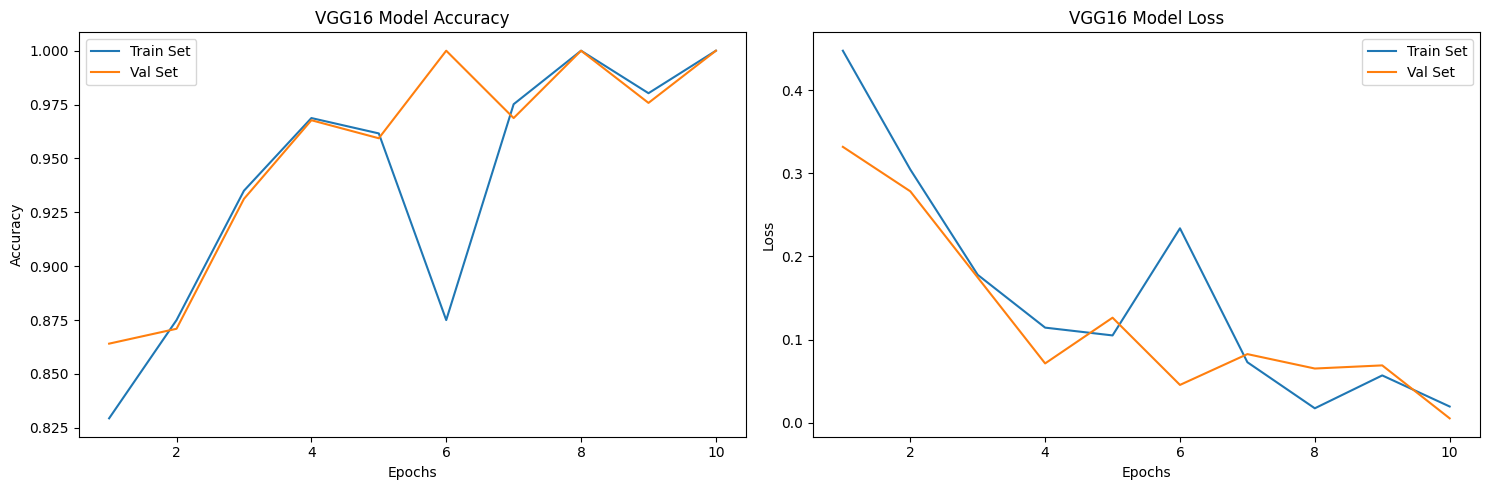

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

**Classification Report (VGG16)**

In [ ]:
all_pred = []
all_true = []

for i in range(41):
    X_test, y_test = next(test_generator)
    pred = model.predict(X_test)

    pred = np.argmax(pred, axis=1)
    y_test_new = np.argmax(y_test, axis=1)


    all_pred.extend(pred)
    all_true.extend(y_test_new)


clear_output()
print(classification_report(all_true, all_pred, target_names=categories))

              precision    recall  f1-score   support

      glioma       1.00      0.91      0.95       300
  meningioma       0.91      0.98      0.95       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



**Confusion Matrix (VGG16)**

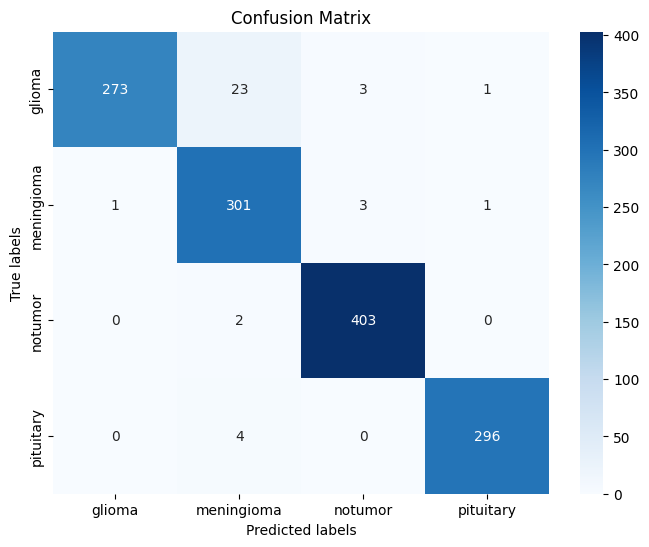

In [ ]:
conf_matrix = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


**ResNet50 Model**

In [ ]:
base_model_resnet = ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

for layer in base_model_resnet.layers:
    layer.trainable = False

base_model_resnet.layers[-2].trainable = True
base_model_resnet.layers[-3].trainable = True
base_model_resnet.layers[-4].trainable = True


model_resnet = Sequential()
model_resnet.add(Input(shape=(256, 256, 3)))
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
model_resnet.add(Dropout(0.3))
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(4, activation='softmax'))


model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_resnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,365,572 (153.98 MB)

 Trainable params: 17,832,580 (68.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [ ]:
model_es = EarlyStopping(
    monitor = 'loss',
    min_delta = 1e-11,
    patience = 12,
    verbose = 1
    )

model_rlr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1
    )

model_mcp = ModelCheckpoint(
    filepath = 'ResNet50_model_weights.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    verbose = 1
    )


**ResNet50 Model Training**

In [ ]:
history_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[model_es, model_rlr, model_mcp]
)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9225 - loss: 0.2091
Epoch 1: val_accuracy did not improve from 0.96774
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.9225 - loss: 0.2092 - val_accuracy: 0.9016 - val_loss: 0.2396 - learning_rate: 1.6000e-07
Epoch 2/20
  1/178 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.7500 - loss: 0.3029
Epoch 2: val_accuracy did not improve from 0.96774
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7500 - loss: 0.3029 - val_accuracy: 0.9355 - val_loss: 0.5340 - learning_rate: 1.6000e-07
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9227 - loss: 0.2104
Epoch 3: val_accuracy did not improve from 0.96774
178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.9227 - loss: 0.2104 - val_accuracy: 0.8977 - val_loss: 0.2508 - learning_rate: 1.6000e-07
Epoch 4/20
  1/178 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.8750 - loss: 0.1750
Epoch 4: val_accuracy did not improve from 0.96774

**Evaluating the Model**

In [ ]:
loss_resnet, accuracy_resnet = model_resnet.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"ResNet50 Test Loss: {loss_resnet:0.5f}")
print(f"ResNet50 Test Accuracy: {accuracy_resnet:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9102 - loss: 0.2331
ResNet50 Test Loss: 0.25439
ResNet50 Test Accuracy: 0.90469


**Plotting Model Performance (ResNet50)**

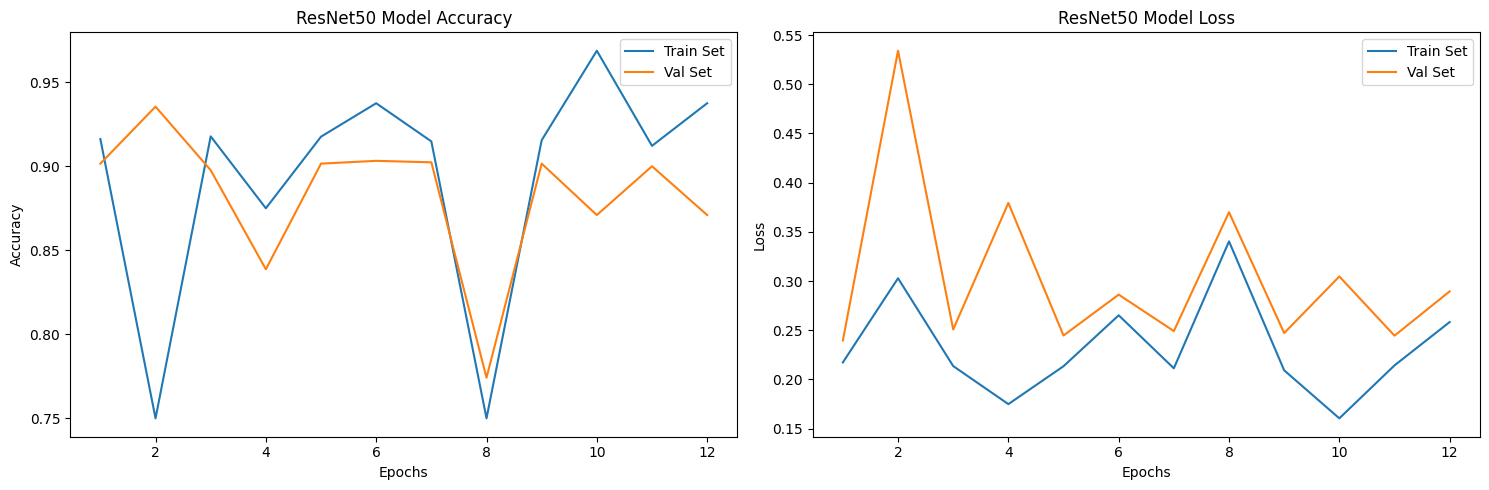

In [ ]:
acc_resnet = history_resnet.history['accuracy']
val_acc_resnet = history_resnet.history['val_accuracy']
loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']
epochs_range_resnet = range(1, len(history_resnet.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_resnet, acc_resnet, label='Train Set')
plt.plot(epochs_range_resnet, val_acc_resnet, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_resnet, loss_resnet, label='Train Set')
plt.plot(epochs_range_resnet, val_loss_resnet, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

**Classification Report (ResNet50)**

In [ ]:
all_pred_resnet = []
all_true_resnet = []

for i in range(test_generator.samples // test_generator.batch_size):
    X_test_resnet, y_test_resnet = next(test_generator)
    pred_resnet = model_resnet.predict(X_test_resnet)

    pred_resnet = np.argmax(pred_resnet, axis=1)
    y_test_new_resnet = np.argmax(y_test_resnet, axis=1)

    all_pred_resnet.extend(pred_resnet)
    all_true_resnet.extend(y_test_new_resnet)

clear_output()
print(classification_report(all_true_resnet, all_pred_resnet, target_names=categories))

              precision    recall  f1-score   support

      glioma       0.90      0.75      0.82       294
  meningioma       0.77      0.87      0.82       294
     notumor       0.97      0.98      0.98       397
   pituitary       0.96      0.98      0.97       295

    accuracy                           0.90      1280
   macro avg       0.90      0.90      0.90      1280
weighted avg       0.91      0.90      0.90      1280



**Confusion Matrix (ResNet50)**

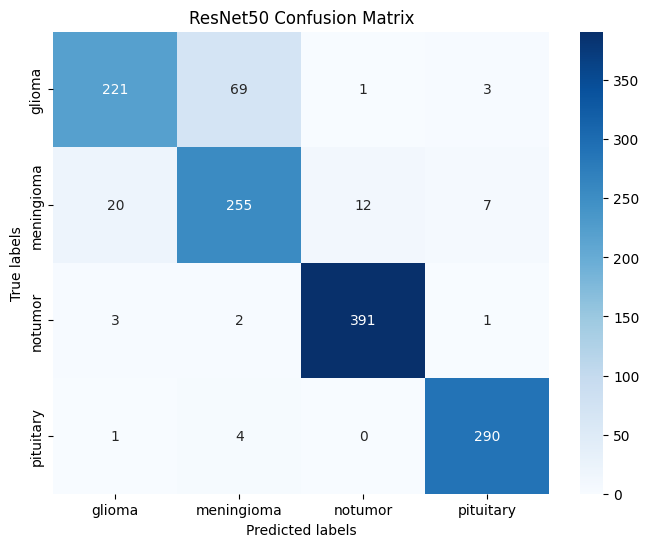

In [ ]:
conf_matrix_resnet = confusion_matrix(all_true_resnet, all_pred_resnet)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('ResNet50 Confusion Matrix')
plt.show()

**ResNet101 Model**

In [ ]:
base_model_resnet101 = ResNet101(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

for layer in base_model_resnet101.layers:
    layer.trainable = False

base_model_resnet101.layers[-2].trainable = True
base_model_resnet101.layers[-3].trainable = True
base_model_resnet101.layers[-4].trainable = True


model_resnet101 = Sequential()
model_resnet101.add(Input(shape=(256, 256, 3)))
model_resnet101.add(base_model_resnet101)
model_resnet101.add(Flatten())
model_resnet101.add(Dropout(0.3))
model_resnet101.add(Dense(128, activation='relu'))
model_resnet101.add(Dropout(0.2))
model_resnet101.add(Dense(4, activation='softmax'))

model_resnet101.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model_resnet101.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 8, 8, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,436,036 (226.73 MB)

 Trainable params: 17,832,580 (68.03 MB)

 Non-trainable params: 41,603,456 (158.70 MB)

In [ ]:
model_es = EarlyStopping(
    monitor = 'loss',
    min_delta = 1e-11,
    patience = 12,
    verbose = 1
    )

model_rlr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1
    )

model_mcp = ModelCheckpoint(
    filepath = 'ResNet101_model_weights.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    verbose = 1
    )

**ResNet101 Model Training**

In [ ]:
history_resnet101 = model_resnet101.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[model_es, model_rlr, model_mcp]
)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8430 - loss: 0.3962
Epoch 1: val_accuracy did not improve from 0.80645
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - accuracy: 0.8430 - loss: 0.3963 - val_accuracy: 0.7937 - val_loss: 0.4634 - learning_rate: 1.0000e-04
Epoch 2/20
  1/178 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.8750 - loss: 0.3042
Epoch 2: val_accuracy did not improve from 0.80645
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.3042 - val_accuracy: 0.7419 - val_loss: 0.5444 - learning_rate: 1.0000e-04
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8389 - loss: 0.4096
Epoch 3: val_accuracy improved from 0.80645 to 0.81094, saving model to ResNet101_model_weights.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 85s 260ms/step - accuracy: 0.8390 - loss: 0.4095 - val_accuracy: 0.8109 - val_loss: 0.4390 - learning_rate: 1.0000e-04
Epoch 4/20
  1/178 ━━━━━━━━━━━━━━━━━━━━ 45s 257ms/step - accuracy: 0.8125 - loss: 0.4

**Evaluating the Model**

In [ ]:
loss_resnet101, accuracy_resnet101 = model_resnet101.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"ResNet101 Test Loss: {loss_resnet101:0.5f}")
print(f"ResNet101 Test Accuracy: {accuracy_resnet101:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.8390 - loss: 0.4146
ResNet101 Test Loss: 0.41923
ResNet101 Test Accuracy: 0.83594


**Plotting Model Performance (ResNet101)**

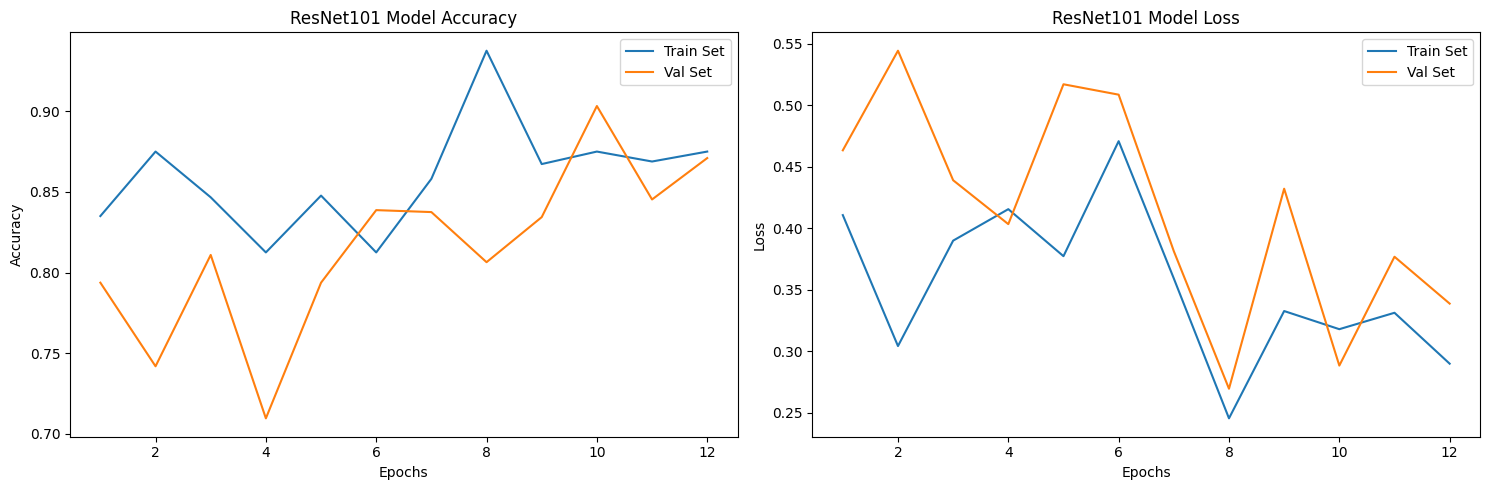

In [ ]:
acc_resnet101 = history_resnet101.history['accuracy']
val_acc_resnet101 = history_resnet101.history['val_accuracy']
loss_resnet101 = history_resnet101.history['loss']
val_loss_resnet101 = history_resnet101.history['val_loss']
epochs_range_resnet101 = range(1, len(history_resnet101.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_resnet101, acc_resnet101, label='Train Set')
plt.plot(epochs_range_resnet101, val_acc_resnet101, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet101 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_resnet101, loss_resnet101, label='Train Set')
plt.plot(epochs_range_resnet101, val_loss_resnet101, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet101 Model Loss')

plt.tight_layout()
plt.show()

**Classification Report (ResNet101)**

In [ ]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
all_pred_resnet101 = []
all_true_resnet101 = []

for i in range(test_generator.samples // test_generator.batch_size):
    X_test_resnet101, y_test_resnet101 = next(test_generator)
    pred_resnet101 = model_resnet101.predict(X_test_resnet101)

    pred_resnet101 = np.argmax(pred_resnet101, axis=1)
    y_test_new_resnet101 = np.argmax(y_test_resnet101, axis=1)

    all_pred_resnet101.extend(pred_resnet101)
    all_true_resnet101.extend(y_test_new_resnet101)


clear_output()
print(classification_report(all_true_resnet101, all_pred_resnet101, target_names=categories))

              precision    recall  f1-score   support

      glioma       0.87      0.64      0.74       292
  meningioma       0.75      0.73      0.74       301
     notumor       0.95      0.95      0.95       395
   pituitary       0.77      0.99      0.87       292

    accuracy                           0.84      1280
   macro avg       0.83      0.83      0.82      1280
weighted avg       0.84      0.84      0.83      1280



**Confusion Matrix (ResNet101)**

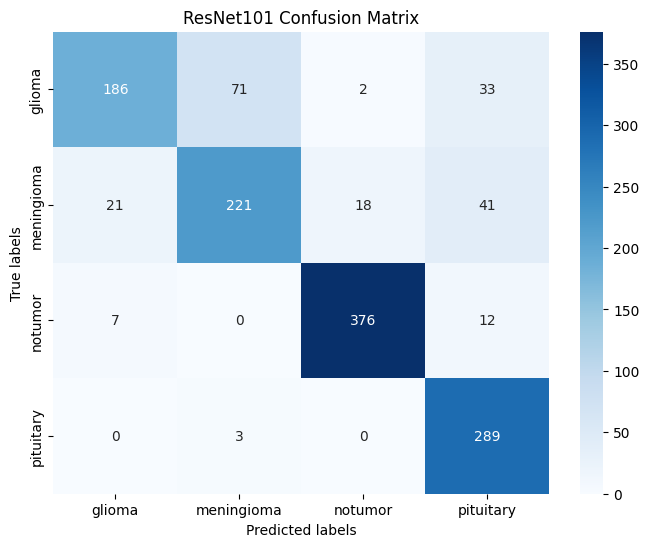

In [ ]:
conf_matrix_resnet101 = confusion_matrix(all_true_resnet101, all_pred_resnet101)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_resnet101, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('ResNet101 Confusion Matrix')
plt.show()

**InceptionV3 Model**

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model_inceptionv3 = InceptionV3(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

base_model_inceptionv3.layers[-2].trainable = True
base_model_inceptionv3.layers[-3].trainable = True
base_model_inceptionv3.layers[-4].trainable = True

model_inceptionv3 = Sequential()
model_inceptionv3.add(Input(shape=(256, 256, 3)))
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dropout(0.3))
model_inceptionv3.add(Dense(128, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(4, activation='softmax'))


model_inceptionv3.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_inceptionv3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       9,437,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,240,612 (119.17 MB)

 Trainable params: 9,437,828 (36.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model_es = EarlyStopping(
    monitor = 'loss',
    min_delta = 1e-11,
    patience = 12,
    verbose = 1
    )

model_rlr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1
    )

model_mcp = ModelCheckpoint(
    filepath = 'InceptionV3_model_weights.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    verbose = 1
    )

**InceptionV3 Model Training**

In [ ]:
history_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[model_es, model_rlr, model_mcp]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7620 - loss: 0.7023
Epoch 1: val_accuracy improved from -inf to 0.89297, saving model to InceptionV3_model_weights.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 71s 236ms/step - accuracy: 0.7624 - loss: 0.7009 - val_accuracy: 0.8930 - val_loss: 0.2818 - learning_rate: 1.0000e-04
Epoch 2/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.8750 - loss: 0.2449

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.89297 to 0.90323, saving model to InceptionV3_model_weights.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.8750 - loss: 0.2449 - val_accuracy: 0.9032 - val_loss: 0.1973 - learning_rate: 1.0000e-04
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9124 - loss: 0.2309
Epoch 3: val_accuracy improved from 0.90323 to 0.93359, saving model to InceptionV3_model_weights.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9124 - loss: 0.2308 - val_accuracy: 0.9336 - val_loss: 0.1775 - learning_rate: 1.0000e-04
Epoch 4/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9062 - loss: 0.1939
Epoch 4: val_accuracy improved from 0.93359 to 0.96774, saving model to InceptionV3_model_weights.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9062 - loss: 0.1939 - val_accuracy: 0.9677 - val_loss: 0.0633 - learning_rate: 1.0000e-04
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step -

**Evaluating the Model**

In [ ]:
loss_inceptionv3, accuracy_inceptionv3 = model_inceptionv3.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"InceptionV3 Test Loss: {loss_inceptionv3:0.5f}")
print(f"InceptionV3 Test Accuracy: {accuracy_inceptionv3:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9487 - loss: 0.1557
InceptionV3 Test Loss: 0.12100
InceptionV3 Test Accuracy: 0.95781


**Plotting Model Performance (InceptionV3)**

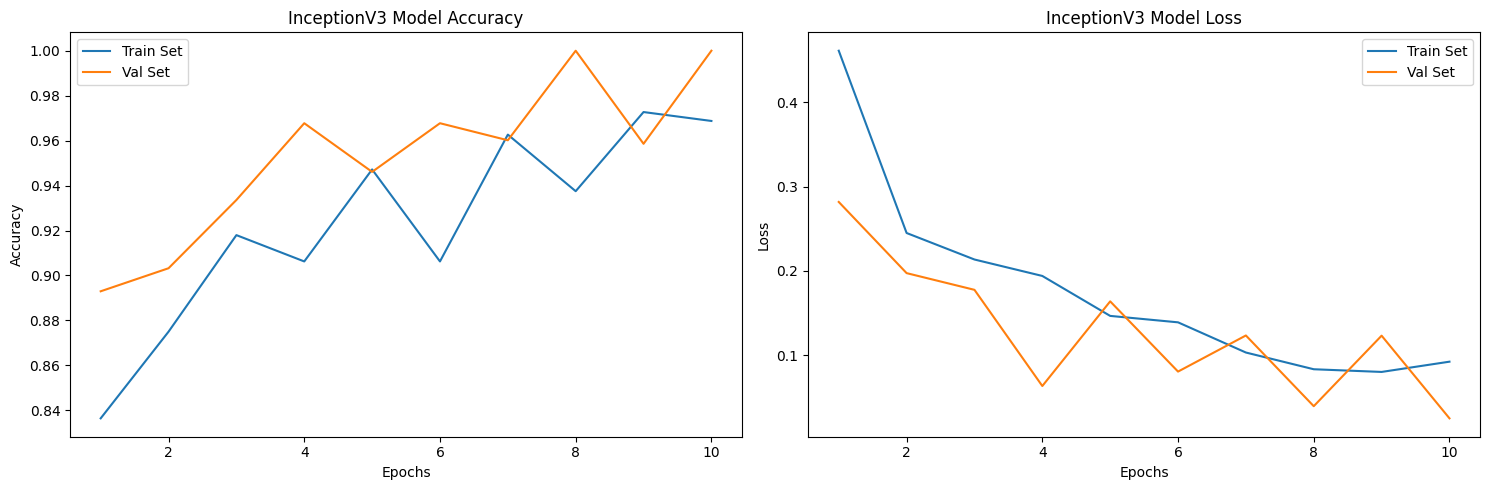

In [ ]:
acc_inceptionv3 = history_inceptionv3.history['accuracy']
val_acc_inceptionv3 = history_inceptionv3.history['val_accuracy']
loss_inceptionv3 = history_inceptionv3.history['loss']
val_loss_inceptionv3 = history_inceptionv3.history['val_loss']
epochs_range_inceptionv3 = range(1, len(history_inceptionv3.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_inceptionv3, acc_inceptionv3, label='Train Set')
plt.plot(epochs_range_inceptionv3, val_acc_inceptionv3, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('InceptionV3 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_inceptionv3, loss_inceptionv3, label='Train Set')
plt.plot(epochs_range_inceptionv3, val_loss_inceptionv3, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('InceptionV3 Model Loss')

plt.tight_layout()
plt.show()

**Classification Report (InceptionV3)**

In [ ]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
all_pred_inceptionv3 = []
all_true_inceptionv3 = []

for i in range(test_generator.samples // test_generator.batch_size):
    X_test_inceptionv3, y_test_inceptionv3 = next(test_generator)
    pred_inceptionv3 = model_inceptionv3.predict(X_test_inceptionv3)

    pred_inceptionv3 = np.argmax(pred_inceptionv3, axis=1)
    y_test_new_inceptionv3 = np.argmax(y_test_inceptionv3, axis=1)

    all_pred_inceptionv3.extend(pred_inceptionv3)
    all_true_inceptionv3.extend(y_test_new_inceptionv3)

clear_output()
print(classification_report(all_true_inceptionv3, all_pred_inceptionv3, target_names=categories))

              precision    recall  f1-score   support

      glioma       0.98      0.87      0.92       290
  meningioma       0.89      0.96      0.93       300
     notumor       0.99      1.00      0.99       391
   pituitary       0.98      0.99      0.99       299

    accuracy                           0.96      1280
   macro avg       0.96      0.96      0.96      1280
weighted avg       0.96      0.96      0.96      1280



**Confusion Matrix (InceptionV3)**

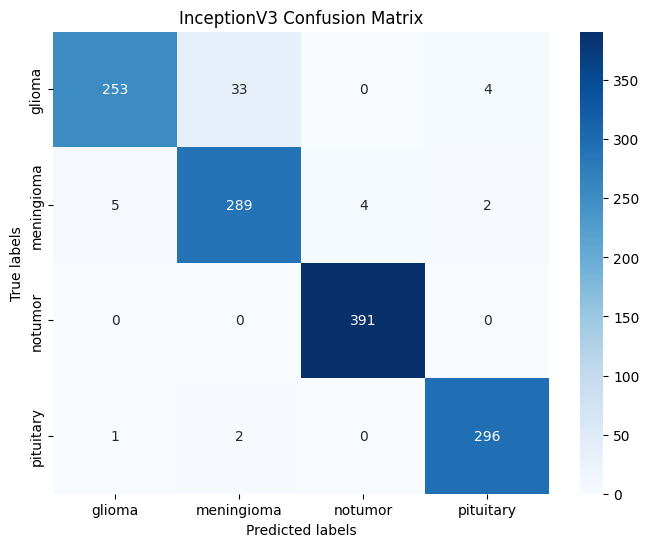

In [ ]:
conf_matrix_inceptionv3 = confusion_matrix(all_true_inceptionv3, all_pred_inceptionv3)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_inceptionv3, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('InceptionV3 Confusion Matrix')
plt.show()
